In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import re
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

## Enron Email Dataset
https://www.kaggle.com/wcukierski/enron-email-dataset

In [ ]:
def search_emails(df, query, by_name=True, by_org=False, by_text=False):
    results = pd.DataFrame()
    
    if by_name:
        results = pd.concat([
            results,
            df[df.sender.apply(lambda x: x.split('@')[0]).str.contains(query)]
        ])

    if by_org:
        results = pd.concat([
            results,
            df[df.sender.apply(lambda x: x.split('@')[-1]).str.contains(query)]
        ])

    if by_text:
        results = pd.concat([
            results,
            df[df.text.str.contains(query)]
        ])
    return results.sort_values(by='date').drop_duplicates()

In [3]:
from collections import Counter

class PGraph:
    def __init__(self, nodes, edges):
        self.nodes = nodes
        self.edges = edges
        
    def node_values(self, idxs, cols=None):
        idxs = list(idxs)
        if cols is None:
            cols = self.nodes.columns.tolist()
            
        return [x for x in self.nodes.loc[idxs][cols].values.reshape(-1) if x!='']
    
    def edge_values(self, idxs, cols=None):
        idxs = list(idxs)
        if cols is None:
            cols = self.nodes.columns.tolist()
            
        if 'sender' in cols:
            return [int(x) for x in self.edges.loc[idxs][cols].values.reshape(-1) if x!='']
        else:
            return [x for x in self.edges.loc[idxs][cols].values.reshape(-1) if x!='']
        
    def uniq_node_values(self, idxs, cols):
        return list(sorted(set(self.node_values(idxs, cols))))
    
    def uniq_edge_values(self, idxs, cols):
        return list(sorted(set(self.edge_values(idxs, cols))))
    
    def node_counts(self, idxs, cols):
        return Counter(self.node_values(idxs, cols))
    
    def edge_counts(self, idxs, cols):
        return Counter(self.edge_values(idxs, cols))

In [15]:
from datetime import datetime
from src.spellcheck import find_close

node_attrs = ['name1', 'name2', 'email1', 'email2', 'org1', 'org2']
edge_bounds = ['sender', 'receiver1', 'receiver2', 'receiver3']

def infer_name(row):
    name = row['email1'].split('@')[0]
    pieces = [x for x in re.split(r'[\.\-\_]', name) if len(x)>0]
    if len(pieces)>=2 and len(pieces[0])>=2:
        return ' '.join(pieces)
    else:
        return ''
    
def infer_org(row):
    suffix = row['email1'].split('@')[-1]
    pieces = [x for x in re.split(r'\.', suffix) if len(x)>0]
    if len(pieces)==2 and pieces[0] not in ['aol', 'earthlink']:
        return pieces[0]
    elif len(pieces)>2 and pieces[-1]=='edu':
        return pieces[-2]
    else:
        return ''
    
def emails2nodes(df):
    emails = np.concatenate([df[x].unique() for x in ['sender', 'recipient1', 'recipient2', 'recipient3']])
    emails = [x for x in np.sort(np.unique(emails)) if len(x)>0]
    
    nodes = pd.DataFrame({k:['']*len(emails) if k!='email1' else emails for k in node_attrs})
    nodes['name1'] = nodes.apply(infer_name, axis=1)
    nodes['org1'] = nodes.apply(infer_org, axis=1)
    nodes = nodes.sort_values(by='org1').reset_index(drop=True)
    return nodes

def emails2edges(df, nodes):
    emails2idx = {v:k for k,v in nodes.to_dict()['email1'].items()}
    
    edges = pd.DataFrame({
        'sender':list(map(emails2idx.get, df['sender'])),
        'receiver1':list(map(emails2idx.get, df['recipient1'])),
        'receiver2':list(map(emails2idx.get, df['recipient2'])),
        'receiver3':list(map(emails2idx.get, df['recipient3'])),
        'type':['email']*len(df),
        'datetime':df['date'].tolist(),
        'desc':df['subject'].tolist(),
        'data':df['text'].tolist()
    }).fillna('')
    
    return edges

def filterby_date(df, start_date=datetime(1979, 1, 1), end_date=datetime(2005, 1, 1)):
    return df[(df.datetime>=start_date)&(df.datetime<=end_date)].reset_index(drop=True)

class ForensicGraph(PGraph):
    @classmethod
    def from_emails(cls, emails_path):
        emails = pd.read_csv(emails_path).fillna('')
        emails['date'] = pd.to_datetime(emails['date'])
        nodes = emails2nodes(emails)
        edges = emails2edges(emails, nodes)
        return cls(nodes=nodes, edges=edges)
    
    def __init__(self, nodes, edges):
        super().__init__(nodes, edges)
        
    def make_subgraph(self, f1, f2=None, start_date=datetime(2001, 1, 1), end_date=datetime(2002, 1, 1)):
        edges = filterby_date(self.edges, start_date=start_date, end_date=end_date)
        edges = self.edges_from_nodes(*f1, edges=edges)
        
        if f2 is not None:
            edges = self.edges_from_nodes(*f2, edges=edges)
            
        nodes = self.nodes_from_edges(*edges.index)
        return PGraph(nodes=nodes, edges=edges)
        
    def edges_from_nodes(self, *nodes, edges=None):
        if edges is None:
            return self.edges[self.edges[edge_bounds].isin(nodes).any(axis=1)]
        else:
            return edges[edges[edge_bounds].isin(nodes).any(axis=1)]
    
    def nodes_from_edges(self, *edges, nodes=None):
        if nodes is None:
            return self.nodes[self.nodes.index.isin(self.uniq_edge_values(edges, edge_bounds))]
        else:
            return nodes[nodes.index.isin(self.uniq_edge_values(edges, edge_bounds))]
    
    def _linked_row(self, *idxs):
        idxs = list(idxs)
        def pair(values):
            return values+['']*(2-len(values)) if len(values)<2 else values[:2]
            
        row = {}
        row['name1'], row['name2'] = pair(self.uniq_node_values(idxs, ['name1', 'name2']))
        row['email1'], row['email2'] = pair(self.uniq_node_values(idxs, ['email1', 'email2']))
        row['org1'], row['org2'] = pair(self.uniq_node_values(idxs, ['org1', 'org2']))
        return pd.Series(row)

    def link(self, *idxs):
        if len(idxs)>1:
            idxs = sorted(idxs)
            prime, aliases = idxs[0], idxs[1:]
            
            self.nodes.loc[prime].update(self._linked_row(*idxs))
            self.nodes = self.nodes.drop(index=aliases)

            edge_repl = dict(zip(aliases, [prime]*len(aliases))) 
            self.edges = self.edges.replace({k:edge_repl for k in edge_bounds})
            
    def search_name(self, name):
        idxs = set()
        idxs.update(find_close(name, self.nodes))
        
        pieces = [x.strip() for x in name.split() if len(x.strip())>0]
        if len(pieces)>=2:
            alt_1 = '.'.join([pieces[0][0], pieces[-1]])
            alt_2 = '.'.join([pieces[0], pieces[-1][0]])
            idxs.update(find_close(alt_1, self.nodes))
            idxs.update(find_close(alt_2, self.nodes))
        return list(sorted(idxs))
    
    def search_names(self, names):
        names = [x.strip() for x in names.split(',')]
        return [self.search_name(x) for x in names]

In [16]:
graph = ForensicGraph.from_emails('data/enron/emails_filtered.csv')

In [17]:
finder = graph.search_names('kenneth lay, jeff skilling')
graph.nodes.loc[finder[0]]
graph.nodes.loc[finder[1]]

,name1,name2,email1,email2,org1,org2
4136,,,klay@enron.com,,enron,
4240,,,k_lay@enron.com,,enron,
4490,kenneth lay,,kenneth_lay@enron.com,,enron,
4498,kenneth lay,,kenneth.lay@enron.com,,enron,


,name1,name2,email1,email2,org1,org2
2761,,,jeff@cclbranding.com,,cclbranding,
2890,,,jeff@cleandrive.net,,cleandrive,
3576,,,kskilling@ehshouston.org,,ehshouston,
5539,,,skilling@enron.com,,enron,
8635,jeff skilling,,jeff_skilling@enron.com,,enron,
8702,jeff skilling,,jeff.skilling@enron.com,,enron,
10532,,,jeff@hoogendam.com,,hoogendam,
11825,,,jeffr@monm.edu,,monm,
12543,,,jeff@pinnaclexec.com,,pinnaclexec,
13271,,,jeff@smartprice.com,,smartprice,


In [18]:
graph.link(*finder[0])
graph.link(8635, 8702)

finder = graph.search_names('kenneth lay, jeff skilling')
graph.nodes.loc[finder[0]]
graph.nodes.loc[finder[1]]

,name1,name2,email1,email2,org1,org2
4136,kenneth lay,,k_lay@enron.com,kenneth.lay@enron.com,enron,


,name1,name2,email1,email2,org1,org2
2761,,,jeff@cclbranding.com,,cclbranding,
2890,,,jeff@cleandrive.net,,cleandrive,
3576,,,kskilling@ehshouston.org,,ehshouston,
5539,,,skilling@enron.com,,enron,
8635,jeff skilling,,jeff.skilling@enron.com,jeff_skilling@enron.com,enron,
10532,,,jeff@hoogendam.com,,hoogendam,
11825,,,jeffr@monm.edu,,monm,
12543,,,jeff@pinnaclexec.com,,pinnaclexec,
13271,,,jeff@smartprice.com,,smartprice,
13762,,,jeffb@tpt.com,,tpt,


In [19]:
poi = [4136, 8635]
assoc = graph.nodes_from_edges(*graph.edges_from_nodes(*poi).index).drop(index=poi).index.tolist()
orgs = [x[0] for x in Counter(graph.nodes.loc[assoc].org1).most_common()]

In [20]:
len(poi)
len(assoc)
len(orgs)

2

1547

599

In [21]:
neworgs = orgs[:10]
newassoc = graph.nodes.loc[assoc]
newassoc = newassoc[newassoc['org1'].isin(neworgs)].index

In [22]:
len(newassoc)
len(neworgs)

859

10

In [35]:
graph.edges

,sender,receiver1,receiver2,receiver3,type,datetime,desc,data
0,6779,1393,,,email,1979-12-31 16:00:00,Re: Update from cousins in Missouri,Letter dictated by Ken Lay Hello Janice: I enj...
1,4953,2794,,,email,1979-12-31 16:00:00,Re: Energy TF Final Report,Mr. Sikes - Kenneth L. Lay is the Chairman of ...
2,4380,9285,,,email,1979-12-31 16:00:00,"Re: BlueDog Change Order #2, Rev 4","Hi Brian, Here are my observations/questions: ..."
3,5816,4015,,,email,1979-12-31 16:00:00,Re: ERMS traders in EnPower,Enron Capital & Trade Resources Corp.
4,6439,9521,,,email,1979-12-31 16:00:00,,"George, In response to your ideas Time and cos..."
...,...,...,...,...,...,...,...,...
62561,679,3708,,,email,2004-02-03 18:19:15,Your code,You have requested an authorization code to va...
62562,13070,4958,,,email,2004-02-03 18:37:41,Give holiday gifts your personal touch!,"Dear Richard, Send personalized holiday treasu..."
62563,672,4416,,,email,2007-02-11 13:32:50,Maud Gordon Elementary Sound,Here is the sound system proposal. References:...
62564,2638,4020,,,email,2044-01-04 08:59:46,Trades,"BOM 5th to 31st traded 34, 33.5 , 33.5 and 34 ..."


In [45]:
def node_summaries(idxs, nodes):
    def summarize(row):
        return row['name1'], row['email1'].split('@')[0], row['org1']
    return {summarize(nodes.loc[idx]):idx for idx in idxs}
    
def edge_summaries(idxs, nodes, edges):
    def summarize(row):
        sender_row = nodes.loc[int(row['sender'])]
        receiver_row = nodes.loc[int(row['receiver1'])]
        sender = sender_row['name1'] if sender_row['name1'] is not '' else sender_row['email1'].split('@')[0]
        receiver = receiver_row['name1'] if receiver_row['name1'] is not '' else receiver_row['email1'].split('@')[0]
        return sender, receiver, row['datetime'].date(), row['desc'][:10]
    return {summarize(edges.loc[idx]):idx for idx in idxs}

In [46]:
node_summaries(assoc, nodes=graph.nodes)

{('', 'quigbe', ''): 1,
 ('', 'ptmather', ''): 11,
 ('', 'prod1', ''): 16,
 ('qwest net', 'qwest.net', ''): 18,
 ('', 'davidcabello', ''): 42,
 ('', 'pln024', ''): 61,
 ('', 'cturcich', ''): 88,
 ('cswanson hull', 'cswanson-hull', ''): 96,
 ('', 'cwhitcomb', ''): 100,
 ('', 'rich7306', ''): 103,
 ('', 'cratmiami', ''): 113,
 ('', 'rkgordon', ''): 114,
 ('', 'cscusack', ''): 126,
 ('', 'rdorr01', ''): 137,
 ('', 'reedglenn', ''): 140,
 ('', 'rbbesco', ''): 145,
 ('', 'razelg', ''): 147,
 ('', 'reslc', ''): 160,
 ('pablo acevedo', 'pablo.acevedo', ''): 178,
 ('', 'dodfraser', ''): 215,
 ('', 'nolesjames', ''): 226,
 ('', 'duozumi', ''): 238,
 ('', 'rltmmb', ''): 261,
 ('', 'delas', ''): 267,
 ('', 'petegohm', ''): 273,
 ('', 'deadmandrj', ''): 295,
 ('', 'philomath', ''): 302,
 ('diego baz', 'diego_baz', ''): 308,
 ('', 'patton', ''): 318,
 ('', 'patrwalke', ''): 320,
 ('', 'dlaws', ''): 323,
 ('', 'diaphone', ''): 328,
 ('', 'dianef', ''): 338,
 ('', 'rmellen', ''): 350,
 ('', 'buckley'

In [47]:
edge_summaries([62561, 62562, 62563], nodes=graph.nodes, edges=graph.edges)

{('chaseonlineplus',
  'vladi pimenov',
  datetime.date(2004, 2, 3),
  'Your code'): 62561,
 ('1800flowers 215124894',
  'rshapiro',
  datetime.date(2004, 2, 3),
  'Give holid'): 62562,
 ('rwalker802',
  'kevin hyatt',
  datetime.date(2007, 2, 11),
  'Maud Gordo'): 62563}

In [23]:
newgraph = graph.make_subgraph(f1=poi, f2=newassoc)

In [27]:
for x in graph.edges:
    print(x)

sender
receiver1
receiver2
receiver3
type
datetime
desc
data


In [25]:
newgraph.nodes

,name1,name2,email1,email2,org1,org2
34,,,daveharkin@aol.com,,,
50,,,poling@westport.msmail.aigfpc.com,,,
53,po jack,,po_jack@email.msn.com,,,
248,,,dplflan@aol.com,,,
306,,,dfarmer@ect.enron.com,,,
...,...,...,...,...,...,...
14313,,,skhanova@wellesley.edu,,wellesley,
14497,,,bsrevada@yahoo.com,,yahoo,
14509,,,rlehmann@yahoo.com,,yahoo,
14561,ssorrels vitoltvl,,ssorrels_vitoltvl@yahoo.com,,yahoo,


In [58]:
orgs = [x[0] for x in org_counts.most_common(10)]

In [59]:
orgs

['enron',
 'yahoo',
 'hotmail',
 'mindspring',
 'mediaone',
 'msn',
 'pacbell',
 'juno',
 'netscape',
 'webtv']

In [43]:
len(assoc)

1547

In [35]:
graph.edges_from_nodes(*poi)

,sender,receiver1,receiver2,receiver3,type,datetime,desc,data
661,7935,4136,,,email,1999-07-27 10:26:00,Re: Contact information,"Try 011-541-14516 6728, you may need the secon..."
694,1266,4136,,,email,1999-08-02 08:33:00,Franco Bernabe's tel number,"Ken, I finally found Franco Bernabe's work num..."
936,7935,4136,11500,,email,1999-09-07 09:04:00,Dress,"Hey there, the dress is at Louise Blum in the ..."
1190,6243,4136,4953,,email,1999-10-15 03:39:00,Federal Legislation Memo,Please see the attached memo from Steve Kean a...
1206,8152,4136,,,email,1999-10-18 05:24:00,Gulfstream Proposal,"Mr. Lay, I have received the proposal from Gul..."
...,...,...,...,...,...,...,...,...
60077,1292,4136,,,email,2002-01-30 11:48:02,Demand Ken Lay Donate Proceeds from Enron Stoc...,"L. Glasner 27 W. 96 St. NY, NY 10025"
60078,10262,4136,,,email,2002-01-30 11:48:02,Demand Ken Lay Donate Proceeds from Enron Stoc...,"Nancy Coates P.O. Box 34 Glenwood, NM 88039"
60079,627,4136,,,email,2002-01-30 11:48:03,Demand Ken Lay Donate Proceeds from Enron Stoc...,"Sara Sandy 903 w Glendale 4 Phoenix, AZ 85021"
60080,11709,4136,,,email,2002-01-30 11:48:04,Demand Ken Lay Donate Proceeds from Enron Stoc...,"Jackie Fung San Francisco, CA 94121"


In [41]:
assoc = graph.nodes_from_edges(*graph.edges_from_nodes(*poi).index).drop(index=poi).index.tolist()

In [33]:
graph.nodes.loc[[x for x in graph.edges_from_nodes(*poi).sender]]

/home/mpark/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,name1,name2,email1,email2,org1,org2
7935.0,elizabeth lay,,elizabeth.lay@enron.com,,enron,
1266.0,,,ggalata@enron.co.uk,,,
7935.0,elizabeth lay,,elizabeth.lay@enron.com,,enron,
6243.0,maureen mcvicker,,maureen.mcvicker@enron.com,,enron,
8152.0,gary fitch,,gary.fitch@enron.com,,enron,
...,...,...,...,...,...,...
1292.0,,,lyngla@earthlink.net,,,
10262.0,,,coates@gilanet.com,,gilanet,
627.0,,,sarasandy@aol.com,,,
11709.0,,,jfung@mh-a.com,,mh-a,


In [ ]:
graph_show = graph._make_subgraph()

In [67]:
graph.edge_counts([3246,3247,3248], ['sender', 'receiver1', 'receiver2'])

Counter({4592: 1, 8702: 1, 3935: 1, 8506: 1, 3893: 1, 6439: 1, 10642: 1})

In [ ]:
graph.node_values([4498], ['name1', 'name2', 'email1'])

In [ ]:
graph.edge_values([3246], ['sender', 'receiver1', 'desc'])

In [27]:
np.unique(graph.edges_from_nodes(4136)[['sender', 'receiver1', 'receiver2', 'receiver3']].replace({'':-1}).values.astype(np.int64))

array([   -1,     1,    11,    16,    18,    61,   100,   103,   113,
         137,   140,   145,   147,   160,   215,   238,   261,   267,
         295,   302,   308,   318,   320,   323,   328,   338,   350,
         378,   381,   382,   386,   394,   415,   417,   434,   457,
         458,   478,   483,   492,   493,   514,   520,   528,   539,
         542,   549,   563,   565,   584,   622,   627,   628,   637,
         644,   646,   653,   673,   682,   688,   690,   696,   730,
         758,   759,   764,   772,   788,   791,   798,   806,   808,
         814,   819,   825,   829,   836,   845,   852,   882,   883,
         897,   902,   903,   912,   921,   924,   934,   951,   969,
         989,   999,  1006,  1009,  1013,  1015,  1016,  1038,  1049,
        1059,  1061,  1072,  1077,  1083,  1084,  1095,  1110,  1113,
        1131,  1147,  1148,  1159,  1188,  1194,  1199,  1216,  1228,
        1234,  1254,  1255,  1263,  1268,  1269,  1274,  1285,  1289,
        1290,  1292,

In [14]:
graph.nodes_from_edges(graph.edges_from_nodes(4136))

[11408.0,
 13838.0,
 3613.0,
 483.0,
 12774.0,
 3126.0,
 10179.0,
 13214.0,
 14305.0,
 14306.0,
 13960.0,
 622.0,
 14307.0,
 10179.0,
 2622.0,
 11605.0,
 622.0,
 11806.0,
 2622.0,
 622.0,
 622.0,
 1113.0,
 6548.0,
 622.0,
 622.0,
 2185.0,
 2185.0,
 13960.0,
 12028.0,
 14040.0,
 6548.0,
 11806.0,
 6548.0,
 7581.0,
 1300.0,
 12776.0,
 622.0,
 10399.0,
 415.0,
 2316.0,
 1013.0,
 2463.0,
 6548.0,
 12843.0,
 7442.0,
 14305.0,
 14305.0,
 1296.0,
 11807.0,
 13595.0,
 11806.0,
 2316.0,
 11902.0,
 9476.0,
 14000.0,
 1393.0,
 903.0,
 13847.0,
 2183.0,
 2184.0,
 2183.0,
 2183.0,
 9420.0,
 12013.0,
 2183.0,
 457.0,
 457.0,
 457.0,
 457.0,
 457.0,
 457.0,
 1745.0,
 2183.0,
 2183.0,
 2183.0,
 2734.0,
 3185.0,
 7526.0,
 457.0,
 215.0,
 14304.0,
 2186.0,
 14304.0,
 637.0,
 12450.0,
 10988.0,
 673.0,
 14273.0,
 10277.0,
 12942.0,
 12848.0,
 3638.0,
 11202.0,
 3544.0,
 2463.0,
 3298.0,
 11508.0,
 11938.0,
 11508.0,
 2186.0,
 11630.0,
 386.0,
 14440.0,
 14305.0,
 323.0,
 14205.0,
 3638.0,
 13701.0,
 2184

In [18]:
find_close('jeff skilling', graph.nodes)

[8635, 8702]

In [19]:
graph.merge(*find_close('jeff skilling', graph.nodes))

In [20]:
find_close('jeff skilling', graph.nodes)

[8635]

In [35]:
graph.edges_from_nodes(8635)

,sender,receiver1,receiver2,receiver3,type,datetime,desc,data
1618,1486,10680,10361,8635,email,1999-12-13 13:16:00,Tom's Alaska Trip & Mother' Telephone,Hello All; Tom is flying to Alaska tomorrow De...
3246,4592,8635,3935,4460,email,2000-03-02 04:05:00,"\tcliff.baxter@enron.com, richard.causey@enron...",Content-Type: text/plain; charset=ANSI_X3.4-19...
3344,9766,8635,,,email,2000-03-06 11:01:00,EBS ASP business and MSFT,"Jeff, Today I had a good discussion with David..."
3875,10973,8635,,,email,2000-03-27 10:14:00,"Phone call, Wednesday",Jeff: I am sending you a business plan for a f...
6237,8655,8635,,,email,2000-06-01 08:26:00,,Why am I not surprised that we'd get smoked on...
...,...,...,...,...,...,...,...,...
50225,14245,8635,,,email,2001-11-01 16:43:49,Votenet Brings NAFSA's National Elections Online,"For Immediate Release Friday, October 12, 2001..."
50475,12849,8635,,,email,2001-11-05 13:14:03,Protect your files and save disk space,(For e-mailing list removal information see bo...
50677,10029,8635,,,email,2001-11-07 07:37:31,Eyeforenergy Announces Next European Events,Eyeforenergy is pleased to announce the latest...
50818,12705,8635,,,email,2001-11-08 07:29:08,FactSet Enhances Communications with Clients,"Dear Jeff, As you know, FactSet has always tak..."


In [37]:
laycoms = [x for x in graph.nodes_from_edges(graph.edges_from_nodes(8635), 'sender', 'receiver1', 'receiver2', 'receiver3')]

In [38]:
len(laycoms)
laycoms

853

[1486.0,
 4592.0,
 9766.0,
 10973.0,
 8655.0,
 8655.0,
 693.0,
 5867.0,
 8655.0,
 6468.0,
 6468.0,
 8192.0,
 3083.0,
 7820.0,
 10383.0,
 7956.0,
 11254.0,
 11254.0,
 405.0,
 7925.0,
 7561.0,
 3839.0,
 8655.0,
 14009.0,
 1472.0,
 8655.0,
 6773.0,
 2214.0,
 2954.0,
 8038.0,
 530.0,
 11458.0,
 13700.0,
 3704.0,
 2913.0,
 10485.0,
 13764.0,
 7732.0,
 530.0,
 4916.0,
 7654.0,
 5826.0,
 6046.0,
 9254.0,
 6614.0,
 5216.0,
 10329.0,
 6804.0,
 8945.0,
 5284.0,
 6630.0,
 14760.0,
 7946.0,
 4706.0,
 9541.0,
 9372.0,
 10243.0,
 6684.0,
 11719.0,
 7819.0,
 667.0,
 3897.0,
 5226.0,
 7710.0,
 3097.0,
 7393.0,
 4561.0,
 4561.0,
 1211.0,
 8655.0,
 14377.0,
 9068.0,
 2811.0,
 3534.0,
 8635,
 6600.0,
 8635,
 2623.0,
 2617.0,
 2617.0,
 2617.0,
 7819.0,
 6363.0,
 5066.0,
 5066.0,
 8635,
 13053.0,
 10535.0,
 12096.0,
 6046.0,
 6897.0,
 8635,
 8057.0,
 8019.0,
 8691.0,
 6494.0,
 8635,
 8635,
 5600.0,
 4420.0,
 5476.0,
 5478.0,
 4971.0,
 8635,
 5600.0,
 6252.0,
 8635,
 8635,
 5321.0,
 5656.0,
 8635,
 9308.0,


In [148]:
Counter([(testy.nodes.loc[x]['email1'], testy.nodes.loc[x]['org1']) for x in laycoms if testy.nodes.loc[x]['org1']!='enron']).most_common()

[(('john@pgsenergy.com', 'pgsenergy'), 10),
 (('enron_update@concureworkplace.com', 'concureworkplace'), 7),
 (('stanmarek@marekbros.com', 'marekbros'), 5),
 (('tskilling@tribune.com', 'tribune'), 4),
 (('hema@izhuta.com', 'izhuta'), 4),
 (('pwhobby@hobbycomm.com', 'hobbycomm'), 3),
 (('kaycole@bu.edu', 'bu'), 3),
 (('georgette@hawkespeers.com', 'hawkespeers'), 3),
 (('kevinscott@onlinemailbox.net', 'onlinemailbox'), 3),
 (('tomskilljr@aol.com', ''), 2),
 (('fredinvt@juno.com', 'juno'), 2),
 (('dandonaldson@att.net', 'att'), 2),
 (('clement@netactive.co.za', ''), 2),
 (('michael.mauboussin@csfb.com', 'csfb'), 2),
 (('veronicapiatigorsky@economist.com', 'economist'), 2),
 (('andy@netconversions.com', 'netconversions'), 2),
 (('sgiridha@prismintl.com', 'prismintl'), 2),
 (('sspar@e-s-x.com', 'e-s-x'), 2),
 (('heath@idealab.com', 'idealab'), 2),
 (('williamk@kroadv.com', 'kroadv'), 2),
 (('whitej@cadvision.com', 'cadvision'), 2),
 (('laura.goldberg@chron.com', 'chron'), 2),
 (('milesa@liv

In [154]:
testy.nodes[testy.nodes.org1=='cadvision']

,name1,name2,email1,email2,org1,org2
2636,,,cmclurg@cadvision.com,,cadvision,
2637,,,laurel@cadvision.com,,cadvision,
2638,,,cramer@cadvision.com,,cadvision,
2639,,,revak@cadvision.com,,cadvision,
2640,,,whitej@cadvision.com,,cadvision,


In [155]:
testy.edges_from_nodes(*testy.nodes[testy.nodes.org1=='cadvision'].index)

,sender,receiver1,receiver2,receiver3,type,datetime,desc,data
16061,7376,2637,,,email,2000-11-05 22:11:00,Re: Ivey Alumni Calgary Event - Nov 9,"Laurel, I have been transferred to Houston, TX..."
37274,7058,2636,,,email,2001-05-22 17:27:00,Re: Wine Picks,are you going to be at the mo vino on thursday...
37478,7058,2636,,,email,2001-05-23 19:36:00,RE: Wine Picks,I'd like to come to Mo Vino - can I register w...
41350,2639,2639,,,email,2001-07-23 18:37:16,CSFA Application,This email is to remind all level 3 CFA candid...
41977,2640,8635,,,email,2001-08-06 11:14:55,"AAA POWER ""Zero Emission"" ""Sulfur Removal Proc...",Dear Mr. Skilling; I've attached the following...
42424,2640,8635,,,email,2001-08-15 10:14:52,"AAA Power Proposal & ""Secrecy Agreement""",Dear Mr. Skilling; I am taking the liberty of ...
54281,2638,4020,,,email,2001-11-29 13:59:46,"Thursday, Nov 29 2001 Trades","Hi, Dec traded 37.75, 37.25, 36.5 and last 36...."
54778,2638,4020,7100,,email,2001-12-06 08:44:17,trades Wednesday dec 5,"Morning John , Dailies traded 32, and 30 Jan t..."
54879,2638,4020,,,email,2001-12-07 10:12:53,"Trades Dec 6 , 2001",Somebody paid up on a Jan-Mar package at 40.5....
55028,2638,4020,,,email,2001-12-10 13:48:46,Trades Dec 7 and Dec 10th,"Howdy , Friday we closed Cal 2002 $39 and Bom ..."


In [156]:
kudcoms = [int(x) for x in testy.vals(testy.edges_from_nodes(*testy.nodes[testy.nodes.org1=='cadvision'].index), 'sender', 'receiver1', 'receiver2', 'receiver3')]

In [157]:
testy.nodes.loc[np.unique(kudcoms)]

,name1,name2,email1,email2,org1,org2
2636,,,cmclurg@cadvision.com,,cadvision,
2637,,,laurel@cadvision.com,,cadvision,
2638,,,cramer@cadvision.com,,cadvision,
2639,,,revak@cadvision.com,,cadvision,
2640,,,whitej@cadvision.com,,cadvision,
4020,john zufferli,,john.zufferli@enron.com,,enron,
7058,cooper richey,,cooper.richey@enron.com,,enron,
7100,cramer erik,,cramer.erik@enron.com,,enron,
7376,chris dorland,,chris.dorland@enron.com,,enron,
8635,jeff skilling,,jeff.skilling@enron.com,jeff_skilling@enron.com,enron,


In [125]:
kudcoms

[11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 11383,
 4490,
 8702,
 4490,
 8702,
 4766,
 4490,
 11383,
 4766,
 4490,
 4490,
 4766,
 4766,
 4490,
 4766,
 4766,
 4766,
 4766,
 4490,
 4766,
 4766,
 4766,
 4766,
 4766,
 4766,
 4766,
 4490,
 4490,
 4490,
 4490,
 4490,
 4490,
 4490,
 4490,
 4490,
 4490]

In [20]:
def filterby_date(df, start_date='1979-01-01', end_date='2005-01-01'):
    return df[(df.date>=start_date)&(df.date<=end_date)].reset_index(drop=True)

def filter_poi(df, poi):
    return df[
        (df.sender.isin(poi))|
        (df.recipient1.isin(poi))|
        (df.recipient2.isin(poi))|
        (df.recipient3.isin(poi))
    ]

def search_emails(df, query, by_name=True, by_org=False, by_text=False):
    results = pd.DataFrame()
    
    if by_name:
        results = pd.concat([
            results,
            df[df.sender.apply(lambda x: x.split('@')[0]).str.contains(query)]
        ])

    if by_org:
        results = pd.concat([
            results,
            df[df.sender.apply(lambda x: x.split('@')[-1]).str.contains(query)]
        ])

    if by_text:
        results = pd.concat([
            results,
            df[df.text.str.contains(query)]
        ])
    return results.sort_values(by='date').drop_duplicates()

In [21]:
data_view = filterby_date(data, start_date='2001-01-01', end_date='2002-01-01')

In [22]:
data_view

,date,subject,sender,recipient1,recipient2,recipient3,text
0,2001-01-01 02:59:00,12/31 Actuals,jeffrey.porter@enron.com,ena.nominations@enron.com,,,"email problems, No temps yet, same as for cast"
1,2001-01-01 06:23:00,Merry Christmas,ps5@andrew.cmu.edu,vince.j.kaminski@enron.com,,,"Dear Mr. Kaminski, In the name of all the MSCF..."
2,2001-01-01 08:36:00,Re: Gas Team - Reorg,john.arnold@enron.com,edie.leschber@enron.com,,,that info is correct.
3,2001-01-01 08:36:00,Re:,john.arnold@enron.com,john.lavorato@enron.com,,,i would have paid you in full Tueday morning a...
4,2001-01-01 08:55:00,,john.arnold@enron.com,mike.maggi@enron.com,,,"if we were open today, where would you open it?"
...,...,...,...,...,...,...,...
34895,2001-12-31 17:18:31,Your Approval is Overdue: Access Request for m...,arsystem@mailman.enron.com,k..allen@enron.com,,,This request has been pending your approval fo...
34896,2001-12-31 17:37:21,Dennis Roddy's Column in the Pittsburgh Post-G...,jerrybowyer@attbi.com,jerrybowyer@attbi.com,,,Please find enclosed a link to a recent Dennis...
34897,2001-12-31 21:53:36,Are You Feeling Lucky Today? ...,cindy@n7.privatenetservers.com,rawls@ectech.com,,,This is the most exciting no download casino o...
34898,2001-12-31 22:17:32,Natural Gas Gridiron Week 16 Results,brian.gore@reliant.com,mariachi.el@enron.com,joe.stepenovitch@enron.com,,Chihuaha That (103 pts) defeated Quieres su pa...


In [23]:
# data = data[data.sender!=data.recipient1]

In [24]:
# ne_sends = data[(~data.sender.apply(lambda x: x.split('@')[-1]).str.contains('enron'))].sender
# ne_recs = data[(~data.recipient1.apply(lambda x: x.split('@')[-1]).str.contains('enron'))].recipient1

In [25]:
# ne_send_dict = {ne_sends.iloc[i]:len(data[data.sender==ne_sends.iloc[i]].recipient1.unique()) for i in range(len(ne_sends))}
# ne_rec_dict = {ne_recs.iloc[i]:len(data[data.sender==ne_recs.iloc[i]].recipient1.unique()) for i in range(len(ne_recs))}

In [26]:
# [x for x in sorted(ne_send_dict.items(), key=lambda x: x[1], reverse=True) if x[0].endswith('')]
# [x for x in sorted(ne_rec_dict.items(), key=lambda x: x[1], reverse=True) if x[0].endswith('')]

In [27]:
# from collections import Counter
# Counter(data[(~data.sender.apply(lambda x: x.split('@')[-1]).str.contains('enron'))].sender).most_common(30)
# Counter(data[(~data.recipient1.apply(lambda x: x.split('@')[-1]).str.contains('enron'))].recipient1).most_common(30)

In [28]:
poi = ['coganja@aol.com', 'stelzer@aol.com', 'kenneth.lay@enron.com', 'hope-frelix@reliantenergy.com', 'susan_j_neel@reliantenergy']
data_graph = filter_poi(data_view, poi)

## Graph Models

In [29]:
def fake_invoice():
    return pd.DataFrame({
        'sender':['patrice.mims@enron', 'set@ercot', 'rosalee.fleming@enron'],
        'recipient':['unknown@reliantenergy', 'unknown@reliantenergy', 'unknown@reliantenergy'],
        'date':['2001-02-15', '2001-11-30', '2001-07-08'],
        'amount':[1000.00, 30000.00, 20000.00],
        'type':['invoice', 'invoice', 'invoice']
    })

In [30]:
fake_invoice()

,sender,recipient,date,amount,type
0,patrice.mims@enron,unknown@reliantenergy,2001-02-15,1000.0,invoice
1,set@ercot,unknown@reliantenergy,2001-11-30,30000.0,invoice
2,rosalee.fleming@enron,unknown@reliantenergy,2001-07-08,20000.0,invoice


In [31]:
data_graph

,date,subject,sender,recipient1,recipient2,recipient3,text
425,2001-01-05 05:07:00,Re: Happy New Year,patrice.mims@enron.com,hope-frelix@reliantenergy.com,,,"Oh Hope, So nice to hear from you! I think abo..."
1278,2001-01-17 02:05:00,Re: Hi,patrice.mims@enron.com,hope-frelix@reliantenergy.com,,,"Hey lady, Just in case you are interested, I c..."
4239,2001-02-15 02:35:00,Re: Hi,patrice.mims@enron.com,hope-frelix@reliantenergy.com,,,"So nice to hear from, it is indeed always a pl..."
4310,2001-02-15 07:15:00,Re: Hi,patrice.mims@enron.com,hope-frelix@reliantenergy.com,,,"As far as vacation, I think we are thinking of..."
6093,2001-03-07 04:27:00,Re: Hi,patrice.mims@enron.com,hope-frelix@reliantenergy.com,,,So nice to hear from you. I miss not being abl...
...,...,...,...,...,...,...,...
34581,2001-12-27 05:41:58,Thanks for the call yesterday!,lsherriff@btinternet.com,kenneth.lay@enron.com,,,Ken Just wanted to thank you for the call yest...
34664,2001-12-27 20:03:31,(Urgent:Dabhol Project and other India matters.),pravas@ruf.rice.edu,kenneth.lay@enron.com,,,"Dear Ken, I am writing to you today RE: The pr..."
34748,2001-12-28 12:09:13,M. Penner Closed January 1st and 2nd,karen@mpenner.com,kenneth.lay@enron.com,,,So that our employees may spend a little extra...
34808,2001-12-29 17:08:10,Words from a Friend,charlswalk@aol.com,kenneth.lay@enron.com,,,Dear Ken: Although Harmolyn and I have wanted ...


In [32]:
from graph_utils import make_circos, get_centrality, get_betweenness

In [33]:
G = nx.from_pandas_edgelist(
    data_graph, 
    'sender', 
    'recipient1', 
    edge_attr=['date', 'subject'], 
    create_using=nx.MultiDiGraph
)
nx.set_node_attributes(G, dict(map(lambda x: (x, {'name':x.split('@')[0], 'org': x.split('@')[-1]}), G.nodes)))
nx.set_edge_attributes(G, dict(map(lambda x: (x, {'type':'email'}), G.edges)))

In [34]:
# G.add_edges_from(nx.from_pandas_edgelist(
#     fake_invoice(), 
#     'sender', 
#     'recipient', 
#     edge_attr=['date', 'amount'], 
#     create_using=nx.MultiDiGraph
# ).edges())

In [35]:
G.edges

OutMultiEdgeView([('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com', 0), ('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com', 1), ('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com', 2), ('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com', 3), ('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com', 4), ('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com', 5), ('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com', 6), ('hope-frelix@reliantenergy.com', 'patrice.l.mims@enron.com', 0), ('hope-frelix@reliantenergy.com', 'patrice.l.mims@enron.com', 1), ('hope-frelix@reliantenergy.com', 'l..mims@enron.com', 0), ('hope-frelix@reliantenergy.com', 'l..mims@enron.com', 1), ('hope-frelix@reliantenergy.com', 'l..mims@enron.com', 2), ('tori.wells@enron.com', 'stelzer@aol.com', 0), ('stelzer@aol.com', 'rosalee.fleming@enron.com', 0), ('stelzer@aol.com', 'rosalee.fleming@enron.com', 1), ('stelzer@aol.com', 'rosalee.fleming@enron.com', 2), ('stelzer@aol.com'

In [36]:
# G.edges[('rosalee.fleming@enron', 'unknown@reliantenergy', 0)]

In [37]:
G.nodes()

NodeView(('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com', 'tori.wells@enron.com', 'stelzer@aol.com', 'rosalee.fleming@enron.com', 'steven.kean@enron.com', 'mike.mcconnell@enron.com', 'kenneth.lay@enron.com', 'patrice.l.mims@enron.com', 'coganja@aol.com', 'barry.tycholiz@enron.com', 'xafira.mendonsa@enron.com', 'jeff.skilling@enron.com', 'morrisjhd@aol.com', 'greg_priest@smartforce.com', 'beau@layfam.com', 'jbarry@eyeforenergy.com', 'courtney.hanson@ourclub.com', 'karen.denne@enron.com', 'lcook@globalcrossing.com', 'steve.kirsch@propel.com', 'janet.butler@enron.com', 'esheridan@uh.edu', 'jtwolfe@uh.edu', 'perfmgmt@enron.com', 'dorothy.dalton@enron.com', 'richarde@centurydev.com', 'smaynes@globalcrossing.com', 'irene.flynn@enron.com', 'ljefferson@jefferson-usa.com', 'jimbrulte@aol.com', 'ehkeditor@hongkong.org', 'traylor@enron.com', 'donnis.traylor@enron.com', 'gihoff@pacbell.net', 'eckels@enron.com', 'diane.eckels@enron.com', '40enron@enron.com', 'gail.kettenbrink@enron.com',

In [38]:
G.edges()

OutMultiEdgeDataView([('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com'), ('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com'), ('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com'), ('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com'), ('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com'), ('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com'), ('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com'), ('hope-frelix@reliantenergy.com', 'patrice.l.mims@enron.com'), ('hope-frelix@reliantenergy.com', 'patrice.l.mims@enron.com'), ('hope-frelix@reliantenergy.com', 'l..mims@enron.com'), ('hope-frelix@reliantenergy.com', 'l..mims@enron.com'), ('hope-frelix@reliantenergy.com', 'l..mims@enron.com'), ('tori.wells@enron.com', 'stelzer@aol.com'), ('stelzer@aol.com', 'rosalee.fleming@enron.com'), ('stelzer@aol.com', 'rosalee.fleming@enron.com'), ('stelzer@aol.com', 'rosalee.fleming@enron.com'), ('stelzer@aol.com', 'klay@enron.com'), ('stelzer@aol.com', 'kl

In [40]:
G.edges[('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com', 0)]

{'date': '2001-01-05 05:07:00',
 'subject': 'Re: Happy New Year',
 'type': 'email'}

In [41]:
G.edges()

OutMultiEdgeDataView([('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com'), ('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com'), ('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com'), ('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com'), ('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com'), ('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com'), ('patrice.mims@enron.com', 'hope-frelix@reliantenergy.com'), ('hope-frelix@reliantenergy.com', 'patrice.l.mims@enron.com'), ('hope-frelix@reliantenergy.com', 'patrice.l.mims@enron.com'), ('hope-frelix@reliantenergy.com', 'l..mims@enron.com'), ('hope-frelix@reliantenergy.com', 'l..mims@enron.com'), ('hope-frelix@reliantenergy.com', 'l..mims@enron.com'), ('tori.wells@enron.com', 'stelzer@aol.com'), ('stelzer@aol.com', 'rosalee.fleming@enron.com'), ('stelzer@aol.com', 'rosalee.fleming@enron.com'), ('stelzer@aol.com', 'rosalee.fleming@enron.com'), ('stelzer@aol.com', 'klay@enron.com'), ('stelzer@aol.com', 'kl

In [42]:
def edges_by_color(G):
    pass

In [43]:
import random
import matplotlib.colors as mcolors

def grouped_layout(G, rad = 3.5):
    random.seed(7)
    colors = list(mcolors.CSS4_COLORS.keys())
    random.shuffle(colors)

    node_network_map = nx.get_node_attributes(G, 'org')
    networks = sorted(list(set(node_network_map.values())))
    color_map = dict(zip(networks, colors[:len(networks)]))
    nodes_by_color = {
        val: [node for node in G if color_map[node_network_map[node]] == val]
        for val in colors
    }
    
    pos = nx.circular_layout(G)   # replaces your original pos=...
    # prep center points (along circle perimeter) for the clusters
    angs = np.linspace(0, 2*np.pi, 1+len(networks))
    repos = []
    
    for ea in angs:
        if ea > 0:
            #print(rad*np.cos(ea), rad*np.sin(ea))  # location of each cluster
            repos.append(np.array([rad*np.cos(ea), rad*np.sin(ea)]))

    color_pos = dict(zip(nodes_by_color.keys(), range(len(nodes_by_color))))

    for ea in pos.keys():
        posx = 0

        for c, p in color_pos.items():
            if ea in nodes_by_color[c]:
                posx = p

        #print(ea, pos[ea], pos[ea]+repos[posx], color, posx)
        pos[ea] += repos[posx]
    return pos, nodes_by_color

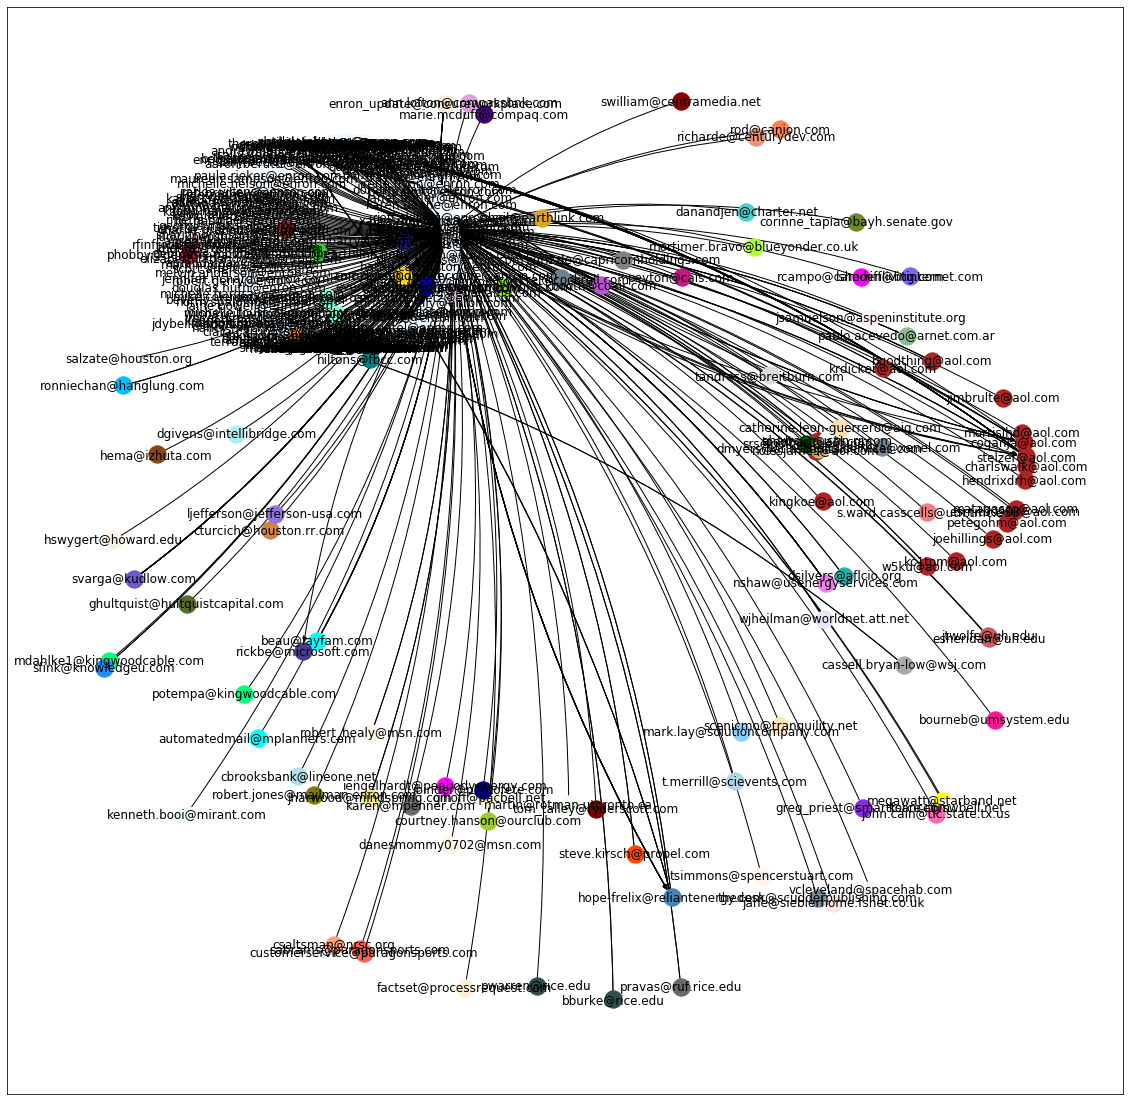

In [44]:
import numpy as np

pos, nodes_by_color = grouped_layout(G, rad=3.5)

#################################
edges = G.edges()

# First draw the nodes 
plt.figure(figsize=(20,20))
for color, node_names in nodes_by_color.items():
    nx.draw_networkx_nodes(G, pos=pos, nodelist=node_names, node_color=color)

# Then draw edges with thickness defined by weights_n
nx.draw_networkx_edges(G, pos=pos, connectionstyle='arc3, rad = 0.1')
nx.draw_networkx_labels(G, pos=pos)
plt.show()
pass;

In [70]:
inv = pd.read_excel('data/invoices/invoices.xlsx').fillna('').drop(columns=['filename', 'name'])
inv = inv[(inv['date']!='')&(inv['amount']!='')]
inv.date = pd.to_datetime(inv.date.apply(lambda x: x.replace(',2',', 2')))
inv = inv.sort_values(by='date')

In [63]:
inv

,vendor_name,date,amount,description,recipient,invoice_number
0,"Absolute Protective Systems, Inc",2020-08-11,$255.90,SERVICE REQUEST/AUTHORIZATION FROM JOHN LAU. L...,Betty S Lau,194060
1,Absolute Protective Systems Inc.,2020-08-11,$255.90,SERVICE REQUEST/AUTHORIZATION FROM JOHN LAU: L...,Betty S Lau,194060
2,"AES ADVANCED ELECTRONIC Solutions, INC",2020-06-29,$383.85,Central Station Alarm Monitoring,Cindy,F23191
3,DPN a talent agency,2020-12-16,"1,100.00",Vo Narration ( $1000+10%- Internet only),Peter Lyons,24073
4,Barclay Brand Ferdon,2020-10-09,191.93,136028 YALE Model GLC030,,12533002
5,Benjamin Thomas Keenan,2020-09-30,$ 647.50,Researching & Excel Work as of September 30th,Peter Lyons,2
7,Benjamin Thomas Keenan,2020-07-03,$573.50,Phase 1 Health & Wellness Category\nPhase 1 Ex...,Wanda,1
10,"Bradley Baron, LLC",2020-12-16,"$1,500.00",Diabetes Video- Ozempic,Wanda,1216-20C
13,"Bradley Baron, LLC",2020-11-06,$750.00,Make up Artist,Wanda,1106-20M
16,"Component Web Services, LLC",2020-04-02,"1,252.84",Siefinity license for myifi.idpractitioner.com,Wanda,12136


In [ ]:
convert_names = {
    'John T Lau': 'kenneth t lay', 
    'John Lau': 'kenneth lay',
    'Betty S Lau': 'jeff s skilling',
    'Betty Lau': 'jeff skilling'
}

convert_orgs = {
    'Ark Technology Solutions LLC':'mindspring',
    'ADP, LLC':'cadvision',
    'FedEx Express':'reliantenergy',
    'FedEx Ground':'reliant',
    'ARGUS LEGAL PLLC':'kudlow'
}

In [53]:
# fig, axs = plt.subplots(2, 1, figsize=(15, 8))

# cent = get_centrality(G)
# centplot = sns.barplot(ax=axs[0], y='centrality', x='name', data=cent.replace({r'\.com$':r''}, regex=True)[:10])
# axs[0].set_xlabel('Degree Centrality')
# axs[0].set_ylabel('')
# axs[0].set_title('Top Degree in Enron Network')
# plt.setp(centplot.get_xticklabels(), rotation=30)

# bet = get_betweenness(G)
# betplot = sns.barplot(ax=axs[1], y='betweenness', x='name', data=bet.replace({r'\.com$':r''}, regex=True)[:10])
# axs[1].set_xlabel('Degree Betweenness Centrality')
# axs[1].set_ylabel('')
# axs[1].set_title('Top Betweenness in Enron Network')
# plt.setp(betplot.get_xticklabels(), rotation=45)

# plt.subplots_adjust(hspace=0.5)
# pass;

In [54]:
from run_clean import name_org

In [55]:
names = nx.get_node_attributes(G, 'name')

['lightseagreen',
 'navajowhite',
 'firebrick',
 'darkseagreen',
 'lavenderblush',
 'darkgreen',
 'darkkhaki',
 'mintcream',
 'olivedrab',
 'greenyellow']

In [68]:
import string, random
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import random as sparse_random

random.seed(0)

# Random string generator
def rand_string(size=6, chars=string.ascii_uppercase):
    return ''.join(random.choice(chars) for _ in range(size))


# Set up a nodes and networks randomly
nodes = [rand_string() for _ in range(30)]
networks = [rand_string() for _ in range(5)]
networks_list = networks*6
random.shuffle(networks_list)

# Define what nodes belong to what network and what their color should be
node_network_map = dict(zip(nodes, networks_list))
colors = colors[:5]
color_map = dict(zip(networks, colors))


In [133]:
node_network_map

{'MYNBIQ': 'RNTDIC',
 'PMZJPL': 'AGFWDP',
 'SGQEJE': 'DUGTSD',
 'YDTZIR': 'RNTDIC',
 'WZTEJD': 'AGFWDP',
 'XCVKPR': 'RNTDIC',
 'DLNKTU': 'MCLDBT',
 'GRPOQI': 'DUGTSD',
 'BZRACX': 'DUGTSD',
 'MWZVUA': 'GXZBVA',
 'TPKHXK': 'GXZBVA',
 'WCGSHH': 'MCLDBT',
 'ZEZROC': 'RNTDIC',
 'CKQPDJ': 'DUGTSD',
 'RJWDRK': 'GXZBVA',
 'RGZTRS': 'GXZBVA',
 'JOCTZM': 'MCLDBT',
 'KSHJFG': 'AGFWDP',
 'FBTVIP': 'GXZBVA',
 'CCVYEE': 'AGFWDP',
 'BCWRVM': 'RNTDIC',
 'WQIQZH': 'MCLDBT',
 'GVSNSI': 'MCLDBT',
 'OPVUWZ': 'DUGTSD',
 'LCKTDP': 'GXZBVA',
 'SUKGHA': 'MCLDBT',
 'XIDWHL': 'RNTDIC',
 'ZFKNBD': 'DUGTSD',
 'ZEWHBS': 'AGFWDP',
 'URTVCA': 'AGFWDP'}

In [69]:
color_map

{'DUGTSD': 'lightseagreen',
 'MCLDBT': 'navajowhite',
 'AGFWDP': 'firebrick',
 'GXZBVA': 'darkseagreen',
 'RNTDIC': 'lavenderblush'}

In [70]:
nodes

['MYNBIQ',
 'PMZJPL',
 'SGQEJE',
 'YDTZIR',
 'WZTEJD',
 'XCVKPR',
 'DLNKTU',
 'GRPOQI',
 'BZRACX',
 'MWZVUA',
 'TPKHXK',
 'WCGSHH',
 'ZEZROC',
 'CKQPDJ',
 'RJWDRK',
 'RGZTRS',
 'JOCTZM',
 'KSHJFG',
 'FBTVIP',
 'CCVYEE',
 'BCWRVM',
 'WQIQZH',
 'GVSNSI',
 'OPVUWZ',
 'LCKTDP',
 'SUKGHA',
 'XIDWHL',
 'ZFKNBD',
 'ZEWHBS',
 'URTVCA']

In [71]:
networks

['DUGTSD', 'MCLDBT', 'AGFWDP', 'GXZBVA', 'RNTDIC']

In [72]:
node_network_map

{'MYNBIQ': 'RNTDIC',
 'PMZJPL': 'AGFWDP',
 'SGQEJE': 'DUGTSD',
 'YDTZIR': 'RNTDIC',
 'WZTEJD': 'AGFWDP',
 'XCVKPR': 'RNTDIC',
 'DLNKTU': 'MCLDBT',
 'GRPOQI': 'DUGTSD',
 'BZRACX': 'DUGTSD',
 'MWZVUA': 'GXZBVA',
 'TPKHXK': 'GXZBVA',
 'WCGSHH': 'MCLDBT',
 'ZEZROC': 'RNTDIC',
 'CKQPDJ': 'DUGTSD',
 'RJWDRK': 'GXZBVA',
 'RGZTRS': 'GXZBVA',
 'JOCTZM': 'MCLDBT',
 'KSHJFG': 'AGFWDP',
 'FBTVIP': 'GXZBVA',
 'CCVYEE': 'AGFWDP',
 'BCWRVM': 'RNTDIC',
 'WQIQZH': 'MCLDBT',
 'GVSNSI': 'MCLDBT',
 'OPVUWZ': 'DUGTSD',
 'LCKTDP': 'GXZBVA',
 'SUKGHA': 'MCLDBT',
 'XIDWHL': 'RNTDIC',
 'ZFKNBD': 'DUGTSD',
 'ZEWHBS': 'AGFWDP',
 'URTVCA': 'AGFWDP'}

In [62]:
graph = nx.Graph()
graph.add_nodes_from(nodes)
nodes_by_color = {val: [node for node in graph if color_map[node_network_map[node]] == val]
                  for val in colors}

In [63]:
nodes_by_color

{'lightseagreen': ['APSFIJ', 'AENRLT', 'VZRMMM', 'DPOPPJ', 'YGZHMX', 'MZWYGP'],
 'navajowhite': ['CFEHVH', 'SKEWQT', 'AYQJUC', 'YHRRYQ', 'XAAZIP', 'PTTAPU'],
 'firebrick': ['UVXBOY', 'KTBDAS', 'CEDXKX', 'IPWFQA', 'GQLEWR', 'ZHGQPL'],
 'darkseagreen': ['GCGOFD', 'ERDLTA', 'KUHTZZ', 'IGWTLO', 'LZUCVD', 'FNZUKC'],
 'lavenderblush': ['MDPUMB', 'CGTMEU', 'ILTLPD', 'WIQLFL', 'ZXLLCH', 'DHPGKG']}

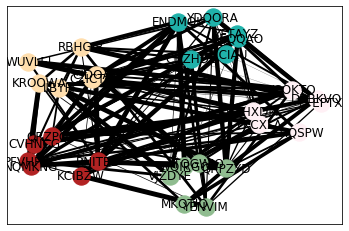

In [64]:
import string, random
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import random as sparse_random


# Random string generator
def rand_string(size=6, chars=string.ascii_uppercase):
    return ''.join(random.choice(chars) for _ in range(size))


# Set up a nodes and networks randomly
nodes = [rand_string() for _ in range(30)]
networks = [rand_string() for _ in range(5)]
networks_list = networks*6
random.shuffle(networks_list)

# Define what nodes belong to what network and what their color should be
node_network_map = dict(zip(nodes, networks_list))
colors = colors[:5]
color_map = dict(zip(networks, colors))

graph = nx.Graph()
graph.add_nodes_from(nodes)
nodes_by_color = {val: [node for node in graph if color_map[node_network_map[node]] == val]
                  for val in colors}

# Take random sparse matrix as adjacency matrix
mat = sparse_random(30, 30, density=0.3).todense()
for row, row_val in enumerate(nodes):
    for col, col_val in enumerate(nodes):
        if col > row and mat[row, col] != 0.0: # Stick to upper half triangle, mat is not symmetric
            graph.add_edge(row_val, col_val, weight=mat[row, col])

# Choose a layout to visualize graph
######################## pos = nx.spring_layout(graph)


import numpy as np
pos = nx.circular_layout(graph)   # replaces your original pos=...
# prep center points (along circle perimeter) for the clusters
angs = np.linspace(0, 2*np.pi, 1+len(colors))
repos = []
rad = 3.5     # radius of circle
for ea in angs:
    if ea > 0:
        #print(rad*np.cos(ea), rad*np.sin(ea))  # location of each cluster
        repos.append(np.array([rad*np.cos(ea), rad*np.sin(ea)]))
        
color_pos = dict(zip(nodes_by_color.keys(), range(len(nodes_by_color))))

for ea in pos.keys():
    #color = 'black'
    posx = 0
    
    for c, p in color_pos.items():
        
        if ea in nodes_by_color[c]:
            #color = 'green'
            posx = p

    #print(ea, pos[ea], pos[ea]+repos[posx], color, posx)
    pos[ea] += repos[posx]


#################################
edges = graph.edges()

# Get the edge weights and normalize them 
weights = [abs(graph[u][v]['weight']) for u, v in edges]
weights_n = [5*float(i)/max(weights) for i in weights] # Change 5 to control thickness

# First draw the nodes 
plt.figure()
for color, node_names in nodes_by_color.items():
    nx.draw_networkx_nodes(graph, pos=pos, nodelist=node_names, node_color=color)

# Then draw edges with thickness defined by weights_n
nx.draw_networkx_edges(graph, pos=pos, width=weights_n)
nx.draw_networkx_labels(graph, pos=pos)
plt.show()
pass;

# Embeddings

In [9]:
import re

def emails_to_sentences(data):
    df_dict = {k:[] for k in data.columns}
    df_dict.pop('text')
    idx = []
    sentence = []
    
    for i, row in data.iterrows():
        sents = re.split(r'(?<=[a-z]{2})\.|\?|\!', row.text)
        n_sents = len(sents)
        for k in df_dict.keys():
            df_dict[k].extend([row[k]]+['']*(n_sents-1))
        idx.extend([i]*n_sents)
        sentence.extend(sents)
    df_dict['idx'] = idx
    df_dict['sentence'] = sentence
    return pd.DataFrame(df_dict)

In [10]:
emails_to_sentences(data)

,date,subject,sender,recipient1,recipient2,recipient3,idx,sentence
0,2001-01-01 02:59:00,12/31 Actuals,jeffrey.porter@enron,ena.nominations@enron,,,0,"email problems, No temps yet, same as for cast"
1,2001-01-01 06:23:00,Merry Christmas,ps5@cmu,vince.j.kaminski@enron,,,1,"Dear Mr. Kaminski, In the name of all the MSCF..."
2,,,,,,,1,Thank you very much for taking the time to co...
3,,,,,,,1,It was greatly appreciated
4,,,,,,,1,"Best regards, Pierre"
...,...,...,...,...,...,...,...,...
196357,,,,,,,40961,References: Oak Forest Elementary Betty Polla...
196358,2044-01-04 08:59:46,Trades,cramer@cadvision,john.zufferli@enron,,,40962,"BOM 5th to 31st traded 34, 33.5 , 33.5 and 34 ..."
196359,,,,,,,40962,q2 traded 32 and 31.5. feb dec traded 35 smal...
196360,2044-01-04 14:48:58,trades,cramer@cadvision,john.zufferli@enron,,,40963,"Howdy, bom went out 35 at 35.5 Feb traded 32.7..."


In [28]:
import torch
import dataclasses
from dataclasses import dataclass
from typing import Any, Callable, Dict, List, Optional, Set, Tuple, Union

from transformers import (
    XLNetModel, 
    XLNetPreTrainedModel, 
    BertPreTrainedModel,
    BertModel,
    T5PreTrainedModel,
    T5Model,
    AutoConfig,
    AutoTokenizer,
)

class BertLastHidden(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.init_weights()
        
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        return outputs.last_hidden_state
    
class EmailDataset(torch.utils.data.Dataset):
    def __init__(self, features):
        self.features = features
        self.label_list = [x.label for x in features]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, i):
        return self.features[i]

    def get_labels(self):
        return self.label_list

class EmailDataCollator:
    def __init__(self, config):
        self.config = config
        
    def _tensorize(self, name, features, dtype):
        return torch.tensor([f.__dict__[name] for f in features], dtype=dtype).unsqueeze(-1)
        
    def __call__(self, features):
        first = features[0]
        batch = {}

        for k,v in first.__dict__.items():
            if isinstance(v, str) or v is None:
                pass
            elif k=='label' or k=='seq_mask':
                batch[k] = self._tensorize(k, features, torch.long)
            elif self.config[k].vector=='embedding':
                batch[k] = self._tensorize(k, features, torch.long)
            elif self.config[k].vector=='onehot':
                batch[k] = one_hot(self._tensorize(k, features, torch.long), self.config[k].size).unsqueeze(1)
            elif self.config[k].vector=='linear':
                batch[k] = self._tensorize(k, features, torch.float).unsqueeze(-1)
            else:
                raise ValueError("unknown vectorization scheme {}".format(self.config[k].vector))
                
            if type(v)==list:
                batch[k] = batch[k].squeeze(-1)
        return batch

In [29]:
pooling_parameters = {
    "summary_activation": "tanh",
    "summary_last_dropout": 0.1,
    "summary_type": "mean",
    "summary_use_proj": True
}

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased', cache_dir=None, use_fast=True)
config = AutoConfig.from_pretrained('bert-base-cased', finetuning_task='mnli', cache_dir=None)
config.update(pooling_parameters)

embedding = BertLastHidden.from_pretrained('bert-base-cased', from_tf=False, config=config, cache_dir=None)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertLastHidden: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertLastHidden from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLastHidden from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
testy = [tokenizer(x, padding='max_length', max_length=80, truncation=True) for x in data.text[:10]][0]
testy = {k:[v] for k,v in testy.items()}
testy

{'input_ids': [[101,
   10632,
   2645,
   117,
   1302,
   21359,
   15279,
   1870,
   117,
   1269,
   1112,
   1111,
   2641,
   102,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0]],
 'token_type_ids': [[0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
  

In [37]:
embedding(**{k:torch.LongTensor(v).to_sparse() if k=='input_ids' else torch.LongTensor(v) for k,v in testy.items()})

RuntimeError: reshape is not implemented for sparse tensors

In [16]:
data

,date,subject,sender,recipient1,recipient2,recipient3,text
0,2001-01-01 02:59:00,12/31 Actuals,jeffrey.porter@enron,ena.nominations@enron,,,"email problems, No temps yet, same as for cast"
1,2001-01-01 06:23:00,Merry Christmas,ps5@cmu,vince.j.kaminski@enron,,,"Dear Mr. Kaminski, In the name of all the MSCF..."
2,2001-01-01 08:36:00,Re: Gas Team - Reorg,john.arnold@enron,edie.leschber@enron,,,that info is correct.
3,2001-01-01 08:36:00,Re:,john.arnold@enron,john.lavorato@enron,,,i would have paid you in full Tueday morning a...
4,2001-01-01 08:55:00,,john.arnold@enron,mike.maggi@enron,,,"if we were open today, where would you open it?"
...,...,...,...,...,...,...,...
40959,2004-02-03 18:19:15,Your code,chaseonlineplus@chase,vladi.pimenov@enron,,,You have requested an authorization code to va...
40960,2004-02-03 18:37:41,Give holiday gifts your personal touch!,1800flowers.215124894@s2u2,rshapiro@enron,,,"Dear Richard, Send personalized holiday treasu..."
40961,2007-02-11 13:32:50,Maud Gordon Elementary Sound,rwalker802@earthlink,kevin.hyatt@enron,,,Here is the sound system proposal. References:...
40962,2044-01-04 08:59:46,Trades,cramer@cadvision,john.zufferli@enron,,,"BOM 5th to 31st traded 34, 33.5 , 33.5 and 34 ..."


In [17]:
[tokenizer(x, padding='max_length', max_length=80, truncation=True) for x in data.text[:10]][0]

{'input_ids': [101, 10632, 2645, 117, 1302, 21359, 15279, 1870, 117, 1269, 1112, 1111, 2641, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [8]:
import logging
from transformers import set_seed, AutoConfig, AutoTokenizer
from transformers.trainer_utils import is_main_process
from src.nlp.glue_utils import (
    ModelArguments, 
    DataTrainingArguments, 
    TrainingArguments, 
    get_labels,
    get_label_to_id,
    GluePreprocessor, 
    AutoPreprocessor,
    ComputeMetrics
)
from datasets import DatasetDict

model_args = ModelArguments(model_name_or_path='bert-base-cased')
data_args = DataTrainingArguments(task_name='mnli', max_seq_length=80)
training_args = TrainingArguments(
    do_train=True, do_eval=True, 
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5, num_train_epochs=4.0,
    output_dir='test_bert_d768_l80',
    overwrite_output_dir=True,
    evaluation_strategy='steps',
    eval_accumulation_steps=1,
    logging_steps=500,
    eval_steps=500,
    local_rank=-1
)

set_seed(9999)

logger = logging.getLogger(__name__)
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if is_main_process(training_args.local_rank) else logging.WARN,
    )

tokenizer = AutoTokenizer.from_pretrained(
    model_args.model_name_or_path,
    cache_dir=model_args.cache_dir,
    use_fast=model_args.use_fast_tokenizer,
)

config = AutoConfig.from_pretrained(
    model_args.model_name_or_path,
    finetuning_task=data_args.task_name,
    cache_dir=model_args.cache_dir,
)

dataset_dict = DatasetDict()
dataset_dict = dataset_dict.load_from_disk('data/nli/mnli_snli_hans')

config.update(get_labels(data_args, dataset_dict))
config.update(get_label_to_id(data_args, config))
config.update({
    "summary_activation": "tanh",
    "summary_last_dropout": 0.1,
    "summary_type": "mean",
    "summary_use_proj": True
})

ModuleNotFoundError: No module named 'src'